In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '..')

from fvm_utils import *
from fipy_simulation import *
import pymc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# `scipy.integrate.solve_ivp` version

Consider $m u'' + \gamma u' + k u = m g$

Let $x = u$ and $y = u'$. Then we have

\begin{align}
    x' &= y \\
    m y' + \gamma y + k x &= m g
\end{align}

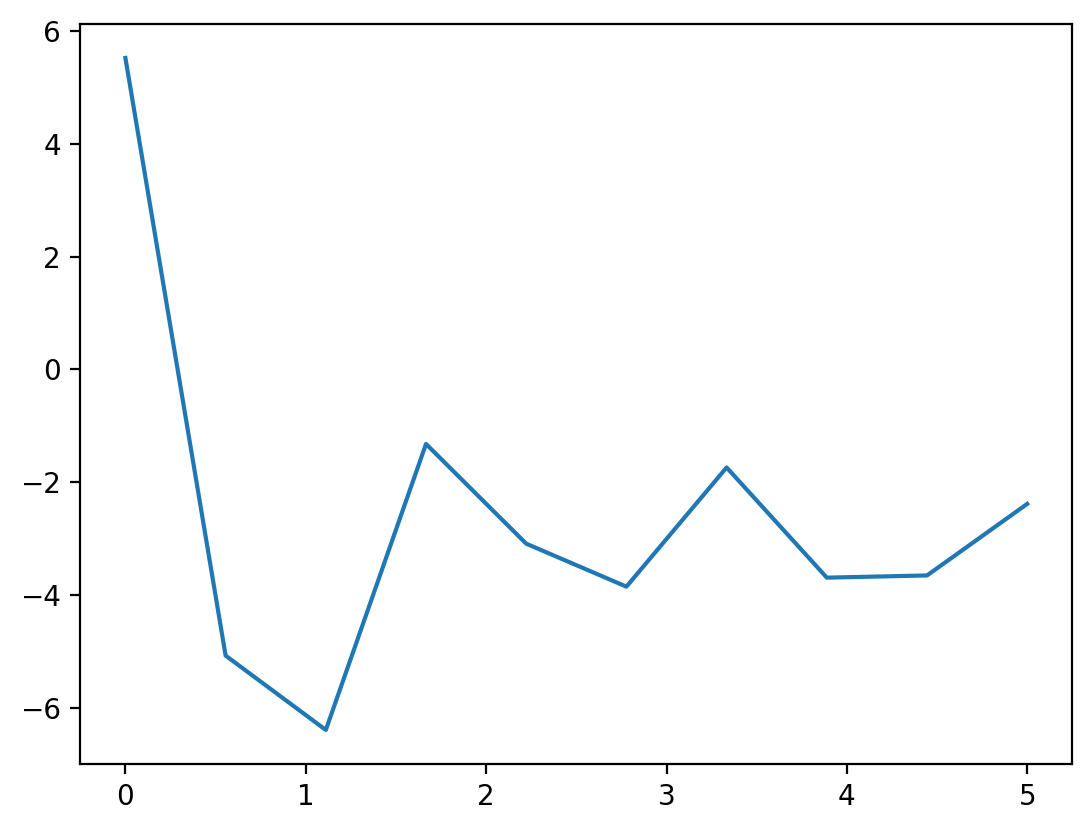

In [3]:
from scipy.integrate import solve_ivp

def func(t, xy, m, gamma, k):
    xp = xy[1]
    yp = -10*m - gamma * xy[1] - k * xy[0]
    return np.array([xp, yp])

def integrate(u0, m, gamma, k, t0=0, tf=5, eval_points=10, sigma=0.5):
    fun = lambda t, xy: func(t, xy, m, gamma, k)

    xy0 = np.array([u0, 0])

    t_eval = np.linspace(t0, tf, eval_points)
    result = solve_ivp(fun, (t0, tf), xy0, t_eval=t_eval)
    t, u = result.t, result.y[0]
    u += np.random.normal(0, sigma, size=u.shape)
    return t, u

t, u = integrate(u0=5, m=5, gamma=1.5, k=15)

fig, ax = plt.subplots(1,1, dpi=200)
ax.plot(t, u)

In [4]:
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pytensor.graph import Op, Apply

def log_likelihood(m, gamma, k, u_true, u0=5, sigma=0.5):
    _, u_pred = integrate(u0=u0, m=m, gamma=gamma, k=k)
    return -(u_true - u_pred)**2 / (2 * sigma**2) - 0.5 * np.log(2 * np.pi * sigma**2)

class LogLikelihood(Op):
    def make_node(self, m, gamma, k, u_true):
        m = pt.as_tensor(m)
        gamma = pt.as_tensor(gamma)
        k = pt.as_tensor(k)
        u_true = pt.as_tensor(u_true)

        inputs = [m, gamma, k, u_true]
        outputs = [u_true.type()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        loglike_eval = log_likelihood(*inputs)
        outputs[0][0] = np.asarray(loglike_eval)

# Generate data to fit
m_true = 5
gamma_true = 1.5
k_true = 15
u0 = 5
t, u_true = integrate(u0=u0, m=m_true, gamma=gamma_true, k=k_true)

loglikelihood_operator = LogLikelihood()
test_out = loglikelihood_operator(m_true, gamma_true, k_true, u_true)

pytensor.dprint(test_out, print_type=True)
out1 = test_out.eval()
out2 = log_likelihood(m_true, gamma_true, k_true, u_true)
print(np.mean(np.power(out1 - out2, 2)))

LogLikelihood [id A] <Vector(float64, shape=(10,))>
 ├─ 5 [id B] <Scalar(int8, shape=())>
 ├─ 1.5 [id C] <Scalar(float32, shape=())>
 ├─ 15 [id D] <Scalar(int8, shape=())>
 └─ [ 4.939703 ... .21950453] [id E] <Vector(float64, shape=(10,))>
1.371680145326035


In [5]:
def custom_log_likelihood(u_true, m, gamma, k):
    return loglikelihood_operator(m, gamma, k, u_true)

with pm.Model() as model:
    m = pm.Normal("m", sigma=5)
    gamma = pm.Normal("gamma", mu=0, sigma=5)
    k = pm.Normal("k", mu=0, sigma=5)

    likelihood = pm.CustomDist("likelihood", m, gamma, k, observed=u_true, logp=custom_log_likelihood)
    samples = pm.sample(1000, tune=100, chains=2, cores=2)

: 

In [ ]:
import seaborn as sns
df = samples.posterior.to_dataframe()
df = df.reset_index().drop('chain', axis=1)
df = df.melt(id_vars='draw')

fig, ax = plt.subplots(1, 1, dpi=100)
plt.rcParams['legend.framealpha'] = 0.
sns.kdeplot(
    data=df,
    bw_adjust=2.5,
    multiple='layer',
    x='value',
    hue='variable',
    ax=ax,
)
ax.axvline(m_true, color='tab:blue', linestyle='--')
ax.axvline(gamma_true, color='tab:orange', linestyle='--')
ax.axvline(k_true, color='tab:green', linestyle='--')

# Fipy version (still buggy)

In [2]:
from fipy.tools.dump import read
from fipy_dataset import FipyDataset
import glob

class FipyLongTimeDataset(FipyDataset):
    """ Dataset that loads longer time sequences from fipy """
    def __init__(self, path="../data/Georgia_Fulton_small/fipy_output", tmax=5):
        super().__init__(path=path)
        self.tmax = tmax

        param_file = glob.glob(f'{path}/../*.json')[0]
        with open(param_file) as f:
            self.params = json.load(f)

    def __len__(self):
        return len(self.files) - self.tmax

    def __getitem__(self, idx):
        if self.data:
            W0, B0, t0 = self.data[idx]
            W1, B1, t1 = self.data[idx+self.tmax]
        else:
            W0, B0, t0 = read(self.files[idx])
            W1, B1, t1 = read(self.files[idx+self.tmax])

        sample = {
            'W0_mesh': W0,
            'B0_mesh': B0,
            'W1_mesh': W1,
            'B1_mesh': B1,
            't0': t0,
            't1': t1
        }

        return sample

def init_variables(sample):
    mesh = sample['W0_mesh'].mesh
    ϕW = sample['W0_mesh']
    μW = fp.CellVariable(name=r"muW", mesh=mesh, hasOld=True)
    ϕB = sample['B0_mesh']
    μB = fp.CellVariable(name=r"muB", mesh=mesh, hasOld=True)
    ϕ0 = 1 - ϕW - ϕB

    return ϕW, μW, ϕB, μB, ϕ0

from argparse import Namespace
def init_equations(ϕW, μW, ϕB, μB, ϕ0, params):
    args = Namespace(**params)
    # Unpack parameters and variables
    TW   = args.tempW
    ΓW   = args.gammaW
    κWW  = args.kWW
    κWB  = args.kWB
    νWWW = args.nuWWW
    νWWB = args.nuWWB
    νWBB = args.nuWBB
    rW = args.growthW

    TB   = args.tempB
    ΓB   = args.gammaB
    κBB  = args.kBB
    κBW  = args.kBW
    νBBB = args.nuBBB
    νBWB = args.nuBWB
    νBWW = args.nuBWW
    rB = args.growthB

    # Build intermediate terms
    mobilityW = ϕW * ϕ0
    πW = κWW * ϕW + κWB * ϕB + νWWW * ϕW * ϕW + νWWB * ϕW * ϕB + νWBB * ϕB * ϕB
    dπWdϕW = κWW + 2 * νWWW * ϕW + νWWB * ϕB
    μW_taylorExpand = -πW + TW * (np.log(ϕW) - np.log(ϕ0))
    dμWdϕW = -dπWdϕW + TW * (1 - ϕB) / (ϕW * ϕ0)
    #SW = rW[0] + rW[1] * ϕW + rW[2] * ϕB + rW[3] * ϕW * ϕW + rW[4] * ϕW * ϕB + rW[5] * ϕB * ϕB
    SW = rW

    mobilityB = ϕB * ϕ0
    πB = κBW * ϕW + κBB * ϕB + νBWW * ϕW * ϕW + νBWB * ϕW * ϕB + νBBB * ϕB * ϕB
    dπBdϕB = κBB + νBWB * ϕW + 2 * νBBB * ϕB
    μB_taylorExpand = -πB + TB * (np.log(ϕB) - np.log(ϕ0))
    dμBdϕB = -dπBdϕB + TB * (1 - ϕW) / (ϕB * ϕ0)
    #SB = rB[0] + rB[1] * ϕW + rB[2] * ϕB + rB[3] * ϕW * ϕW + rB[4] * ϕW * ϕB + rB[5] * ϕB * ϕB
    SB = rB
    
    eqW_1 = (fp.TransientTerm(var=ϕW) == fp.DiffusionTerm(coeff=mobilityW, var=μW) + SW)
    eqW_2 = (fp.ImplicitSourceTerm(coeff=1, var=μW)
             == fp.ImplicitSourceTerm(coeff=dμWdϕW, var=ϕW)
             - dμWdϕW * ϕW + μW_taylorExpand
             - fp.DiffusionTerm(coeff=ΓW, var=ϕW))
    
    eqB_1 = (fp.TransientTerm(var=ϕB) == fp.DiffusionTerm(coeff=mobilityB, var=μB) + SB)
    eqB_2 = (fp.ImplicitSourceTerm(coeff=1, var=μB)
             == fp.ImplicitSourceTerm(coeff=dμBdϕB, var=ϕB)
             - dμBdϕB * ϕB + μB_taylorExpand
             - fp.DiffusionTerm(coeff=ΓB, var=ϕB))
    
    eq = eqW_1 & eqW_2 & eqB_1 & eqB_2
    return eq

def run_simulation(sample, params):
    ϕW, μW, ϕB, μB, ϕ0 = init_variables(sample)
    equations = init_equations(ϕW, μW, ϕB, μB, ϕ0, params)

    t0, t1 = sample['t0'], sample['t1']
    dt = params.get('dt', 0.1)
    t_curr = t0

    print(f'Simulating from {t0:.2g} to {t1:.2g}')

    while t_curr < t1:
        for var in [ϕW, μW, ϕB, μB]:
            var.updateOld()
        res = 1e10
        while res > 1e-5:
            res = equations.sweep(dt=dt)
        t_curr += dt
    
    mseB = np.mean((sample['B1_mesh'] - ϕB.value)**2)
    mseW = np.mean((sample['W1_mesh'] - ϕW.value)**2)

    return ϕB, ϕW, mseB, mseW

dataset = FipyLongTimeDataset(tmax=2)
sample = dataset[10]
prediction = run_simulation(sample, dataset.params)

Fipy data files will be read in at runtime
Simulating from 1.1 to 1.3


ϕB was predicted with MSE = 8.61e-06
ϕW was predicted with MSE = 9.75e-07


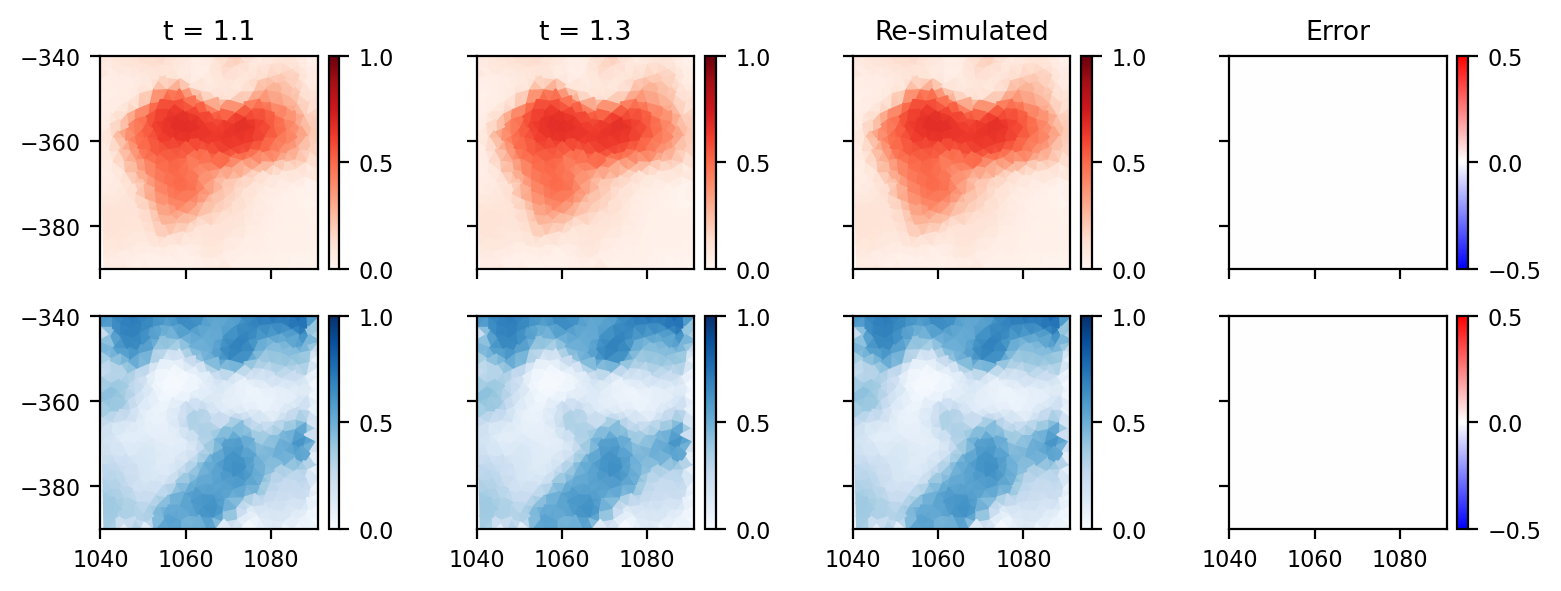

In [3]:
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(2, 4, figsize=(8, 3), sharex=True, sharey=True)

print(f'ϕB was predicted with MSE = {prediction[2]:.3g}')
print(f'ϕW was predicted with MSE = {prediction[3]:.3g}')

kwargs = dict(cmap=plt.cm.Reds, vmin=0, vmax=1)
plot_mesh(sample['B0_mesh'], sample['B0_mesh'].mesh, ax[0,0], **kwargs)
plot_mesh(sample['B1_mesh'], sample['B1_mesh'].mesh, ax[0,1], **kwargs)
plot_mesh(prediction[0], prediction[0].mesh, ax[0,2], **kwargs)

kwargs = dict(cmap=plt.cm.Blues, vmin=0, vmax=1)
plot_mesh(sample['W0_mesh'], sample['W0_mesh'].mesh, ax[1,0], **kwargs)
plot_mesh(sample['W1_mesh'], sample['W1_mesh'].mesh, ax[1,1], **kwargs)
plot_mesh(prediction[1], prediction[1].mesh, ax[1,2], **kwargs)

kwargs = dict(cmap=plt.cm.bwr, vmin=-0.5, vmax=0.5)
plot_mesh(prediction[0]-sample['B0_mesh'], sample['B0_mesh'].mesh, ax[0,3], **kwargs)
plot_mesh(prediction[1]-sample['W0_mesh'], sample['W0_mesh'].mesh, ax[1,3], **kwargs)

ax[0,0].set_title(f't = {sample["t0"]:g}')
ax[0,1].set_title(f't = {sample["t1"]:g}')
ax[0,2].set_title(f'Re-simulated')
ax[0,3].set_title('Error')

plt.tight_layout()